In [1]:
from hdmm import workload
import autograd.numpy as np
from autograd import grad

In [20]:
def loss1(z):
    # total squared error
    return np.sum(z), np.ones(z.size)

def loss2(z):
    # max error
    m = np.max(z)
    return m, (z == m).astype(float)

def loss3(z, z2):
    # inverse variance weighting with prior measurements
    ans = np.sum(1.0 / (1.0/z + 1.0/z2))
    grad = 1.0 / (z/z2 + 1.0)**2
    return ans, grad

def loss4(z, alpha=0.5):
    # a fairness objective
    diff = z - np.mean(z)
    ans = np.sum(z) + alpha*np.dot(diff, diff)
    dd = alpha*2*diff
    dz = 1 + dd - np.mean(dd)
    return ans, dz

def error(W, A, loss):
    AtA = np.dot(A.T, A)
    AtA1 = np.linalg.inv(AtA)
    X = np.dot(W, np.dot(AtA1, W.T))
    z = np.diag(X)
    return loss(z)[0]

def loss_and_grad(W, A, loss):
    AtA = A.T @ A
    AtA1 = np.linalg.inv(AtA)
    X = W @ AtA1 @ W.T
    z = np.diag(X)
    
    L, dz = loss(z)
    
    dX = np.diag(dz)
    dAtA1 = W.T @ dX @ W
    dAtA = -AtA1 @ dAtA1 @ AtA1
    dA = 2 * A @ dAtA
    return L, dA
    
gradient2 = grad(error, argnum=1)

In [3]:
W = workload.Prefix(8).dense_matrix()
A = np.vstack([np.eye(8), np.random.rand(2,8)])

loss = loss4

L, G = loss_and_grad(W, A, loss)
G2 = gradient2(W, A, loss)
print(L, error(W, A, loss))
print(np.linalg.norm(G - G2))

17.844816689599075 17.844816689599075
8.819429690800469e-15


In [4]:
z = np.random.rand(5)

print(loss4(z)[1])
print(grad(lambda z: loss4(z)[0], argnum=0)(z))

[1.00317966 0.78093596 1.1770903  1.31466149 0.72413259]
[1.00317966 0.78093596 1.1770903  1.31466149 0.72413259]


In [5]:
def pid_loss_and_grad(W, params, loss):
    
    n = W.shape[1]
    p = params.size // n
    B = np.reshape(params, (p, n))
    scale = 1.0 + np.sum(B, axis=0)
    R = np.linalg.inv(np.eye(p) + B @ B.T)
    AtA1 = (np.eye(n) - B.T @ R @ B) * scale * scale[:,None]
    X = W @ AtA1 @ W.T
    z = np.diag(X)
    
    L, dz = loss(z)
    
    dX = np.diag(dz)
    dAtA1 = W.T @ dX @ W
    dAtA = -AtA1 @ dAtA1 @ AtA1
    
    Y1 = 2*np.diag(dAtA) / scale
    Y2 = np.dot(2*B/scale, dAtA)
    g = Y1 + np.sum(B*Y2, axis=0)
    dparams = (Y2*scale - g) / scale**2
    
    return L, dparams.flatten()

In [155]:
W = workload.Prefix(8).dense_matrix()
params = np.random.rand(16)

loss = loss1

def foo(W, p, l):
    return pid_loss_and_grad(W, p, l)[0]

gradient2 = grad(foo, argnum=1)

L, G = pid_loss_and_grad(W, params, loss)
G2 = gradient2(W, params, loss)
print(np.linalg.norm(G - G2))

2.690851255287455e-14


In [41]:
### Optimizing max error for Identity + Prefix
from scipy import optimize

n = 64
p = n // 16

W = workload.VStack([workload.Prefix(n), workload.Identity(n)]).dense_matrix()

x0 = np.random.rand(p*n)
bnds = [(0,None)]*x0.size

foo = lambda params: pid_loss_and_grad(W, params, loss1)
res1 = optimize.minimize(foo, x0, jac=True, method='L-BFGS-B', bounds=bnds)

bar = lambda params: pid_loss_and_grad(W, params, loss2)
res2 = optimize.minimize(bar, x0, jac=True, method='L-BFGS-B', bounds=bnds)

fair = lambda z: ((np.max(np.sqrt(z)[n:]) - np.min(np.sqrt(z)[n:])) / np.mean(np.sqrt(z)[n:]), np.zeros_like(z))
baz = lambda params: pid_loss_and_grad(W, params, fair)

def summary(params):
    print(np.sqrt(foo(params)[0]/2/n), np.sqrt(bar(params)[0]), baz(params)[0])
    
summary(res1.x)
summary(res2.x)
summary(np.zeros_like(x0))

#print(np.sqrt(foo(res1.x)[0]/2/n), np.sqrt(foo(res2.x)[0]/2/n))
#print(np.sqrt(bar(res1.x)[0]), np.sqrt(bar(res2.x)[0]))
#print(baz(res1.x)[0], baz(res2.x)[0])


2.917847611572098 4.772177157394109 0.5208900701075476
3.1730686455576644 4.083568153596372 0.5885266532278465
4.092676385936225 8.0 0.0


In [190]:
from scipy import optimize
import matplotlib.pyplot as plt

n = 256
p = n // 16

W = workload.Prefix(n).dense_matrix()
x0 = np.random.rand(p*n)
bnds = [(0,None)]*(p*n)

foo = lambda params: pid_loss_and_grad(W, params, loss1)
res1 = optimize.minimize(foo, x0, jac=True, method='L-BFGS-B', bounds=bnds)
A1 = np.vstack([np.eye(n), res1.x.reshape(p,n)])
A1 /= A1.sum(axis=0)

foo = lambda params: pid_loss_and_grad(W, params, loss4)
res2 = optimize.minimize(foo, x0, jac=True, method='L-BFGS-B', bounds=bnds)
A2 = np.vstack([np.eye(n), res2.x.reshape(p,n)])
A2 /= A2.sum(axis=0)

print(error(W, A1, loss1), error(W, A2, loss1), error(W, np.eye(n), loss1))

6873.125548990568 7157.628001019397 32896.0


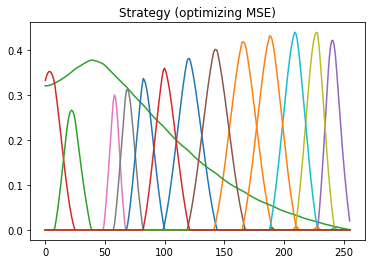

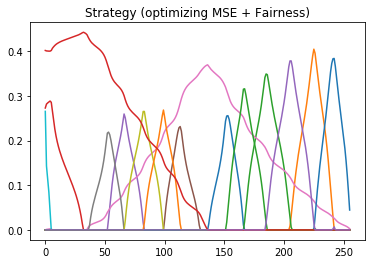

In [205]:
idx = (A1 > 0).sum(axis=1) > 1
plt.title('Strategy (optimizing MSE)')
plt.plot(A1[idx].T)
plt.show()

plt.title('Strategy (optimizing MSE + Fairness)')
idx = (A2 > 0).sum(axis=1) > 1
plt.plot(A2[idx].T)
plt.show()

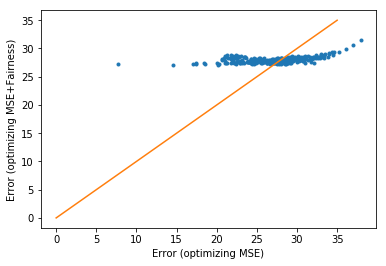

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 154.,  92.,
          8.,   1.,   1.,   0.,   0.,   0.,   0.,   0.]),
 array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]),
 <a list of 30 Patch objects>)

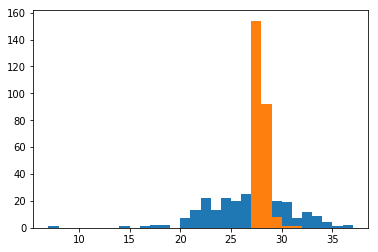

In [199]:
from hdmm.error import per_query_error

x = per_query_error(W, A1)
y = per_query_error(W, A2)
plt.plot(x, y, '.')
plt.plot(np.linspace(0,35), np.linspace(0, 35))
plt.xlabel('Error (optimizing MSE)')
plt.ylabel('Error (optimizing MSE+Fairness)')
plt.show()

plt.hist(x,bins=range(7,38))
plt.hist(y, bins=range(7,38))

In [ ]:
def kron_pid_loss(W, params, loss):
    
    n = W.shape[1]
    p = params.size // n
    B = np.reshape(params, (p, n))
    scale = 1.0 + np.sum(B, axis=0)
    R = np.linalg.inv(np.eye(p) + B @ B.T)
    AtA1 = (np.eye(n) - B.T @ R @ B) * scale * scale[:,None]
    X = W @ AtA1 @ W.T
    z = np.diag(X)
    
    L, dz = loss(z)
    
    dX = np.diag(dz)
    dAtA1 = W.T @ dX @ W
    dAtA = -AtA1 @ dAtA1 @ AtA1
    
    Y1 = 2*np.diag(dAtA) / scale
    Y2 = np.dot(2*B/scale, dAtA)
    g = Y1 + np.sum(B*Y2, axis=0)
    dparams = (Y2*scale - g) / scale**2
    
    return L, dparams.flatten()